# Navigation

---

The Navigation project entails navigating an environment with yellow and blue bananas and eating yellow bananas for a reward and avoiding blue bananas (we get penalized for eating blue ones). We will investigate, implement and assess various Deep Q-Network (DQN) Algorithms that maximize rewards and minimize number of training episodes:
- Deep Q-Network (DQN);
- Deep Reinforcement Learning with Experience Replay and Prioritized Experience Replay;
- Deep Reinforcement Learning with Double Deep Q-Network;
- Deep Reinforcement Learning with Duelling Deep Q-Network Architecture;
- Potential extensions to the above algorithms;

### 1. Load dependencies

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [24]:
!pip -q install ./python

In [25]:
import os
import sys
import time
import numpy as np
import random
from collections import namedtuple, deque
import operator
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from unityagents import UnityEnvironment
%matplotlib inline

# check Python version
if (sys.version_info[0] < 3):
    raise Exception("ERROR: ML-Agents Toolkit (v0.3 onwards) requires Python 3")
else:
    print("[ info ] Python version:")
    print(sys.version)

[ info ] Python version:
3.6.3 | packaged by conda-forge | (default, Dec  9 2017, 04:28:46) 
[GCC 4.8.2 20140120 (Red Hat 4.8.2-15)]


### 2. The Banana Environment. 
The Banana environment is already stored in a local file in the Workspace. Which must be downloaded first to be loaded using UnityEnvironment.

In [26]:
path_to_env = os.path.join(os.getcwd(), '/data/Banana_Linux_NoVis/Banana.x86_64')
env = UnityEnvironment(file_name = path_to_env)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [27]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [28]:
print('[ info ] Brain name',brain_name)
print('[ info ] Brain', brain)

[ info ] Brain name BananaBrain
[ info ] Brain Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


### 3. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [29]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)

state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [ 1.          0.          0.          0.          0.84408134  0.          0.
  1.          0.          0.0748472   0.          1.          0.          0.
  0.25755     1.          0.          0.          0.          0.74177343
  0.          1.          0.          0.          0.25854847  0.          0.
  1.          0.          0.09355672  0.          1.          0.          0.
  0.31969345  0.          0.        ]
States have length: 37


### 4. DQN Network Architectures
At the heart of our DQN Algorithms are the Neural Networks that map states to action values:
1. The first is a standard DQN Neural Network with 3 fully-connected layers that maps states to action values.
2. The second is a Dueling DQN Neural Network with an a 2-layer fully connected advantage network and 2 layer fully connected value network.

In [30]:
class QNetwork(nn.Module):
    """
    Actor (Policy) Model.
    """
    def __init__(self, state_size, action_size, seed, 
                 fc1_units = 256, fc2_units = 64):
        """
        Initialize parameters and build our model
        Params
        ======
        state_size (int): Dimension of each state
        action_size (int): Dimension of each action
        seed (int): Random seed
        fc1_units (int): Number of nodes in first hidden layer
        fc2_units (int): Number of nodes in second hidden layer
        """
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
    def forward(self, state):
        """
        Build a network that maps state -> action values.
        """
        x = self.fc1(state)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        return self.fc3(x)

In [31]:
net = QNetwork(37, 4, seed = 0)
net

QNetwork(
  (fc1): Linear(in_features=37, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=4, bias=True)
)

### 5. Configure hyper parameters for our Networks
Hyper parameters for the network architecture and agent

In [32]:
"""
replay buffer size, minibatch size, discount factor,
for soft update of target parameters, learning rate
"""
params = {"buffer_size":int(1e6),
         "batch_size":64,
         "gamma":0.99,
         "tau":1e-3,
         "learning_rate":5e-4,
          "eps":0.,
         "update_every":4,
         "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu")}

In [33]:
params

{'buffer_size': 1000000,
 'batch_size': 64,
 'gamma': 0.99,
 'tau': 0.001,
 'learning_rate': 0.0005,
 'eps': 0.0,
 'update_every': 4,
 'device': device(type='cpu')}

### 6. ReplayBuffer
A replay buffer is an attribute of an Agent which enables the agent to learn from experience. Discarding experiences, after updates, has two major issues:
- The agent may learn from strongly correlated updates that break i.i.d assumption of many popular stochastic gradient-based algorithms;
- The agent may forget rare experiences which could be useful later;
Some experiences are more useful than others (how do we access these?) and experience replay can be more efficient at computation than the interaction between the agent and its environment.

The following is an implmentation of a basic replay buffer.

In [34]:
class ReplayBuffer(object):
    """
    Fixed-sized buffer to store experience tuples.
    Adapted from Deep Reinforcement Class example and 
    https://github.com/openai/baselines/deepq/replay_buffer.py
    """
    def __init__(self, action_size, buffer_size, batch_size, seed = 0):
        """Initialize a ReplayBuffer object.
        Parameters
        ----------
        action_size (int): dimension of action
        buffer_size (int): Max number of transitions to store in the buffer. When the buffer
            overflows the old memories are dropped.
        batch_size (int): size of each training batch
        seed (int): random seed
        """
        self._storage = []
        self._maxsize = buffer_size
        self.action_size = action_size
        self.batch_size = batch_size
        self.experience = namedtuple('Experience', 
                                     field_names=['state',
                                                  'action',
                                                  'reward',
                                                  'next_state',
                                                  'done'])
        self.seed = seed
        self._next_idx = 0

    def __len__(self):
        return len(self._storage)

    def add(self, obs_t, action, reward, obs_tp1, done):
        #data = (obs_t, action, reward, obs_tp1, done)
        e = self.experience(obs_t, action, reward, obs_tp1, done)

        if self._next_idx >= len(self._storage):
            self._storage.append(e)
        else:
            self._storage[self._next_idx] = e
        self._next_idx = (self._next_idx + 1) % self._maxsize

    def _encode_sample(self, idxes):

        experiences = [self._storage[i] for i in idxes]

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(params['device'])
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(params['device'])
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(params['device'])
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(params['device'])
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(params['device'])

        return (states, actions, rewards, next_states, dones)

    def sample(self):
        """Sample a batch of experiences.
        Parameters
        ----------
        batch_size: int
            How many transitions to sample.
        Returns
        -------
        obs_batch: np.array
            batch of observations
        act_batch: np.array
            batch of actions executed given obs_batch
        rew_batch: np.array
            rewards received as results of executing act_batch
        next_obs_batch: np.array
            next set of observations seen after executing act_batch
        done_mask: np.array
            done_mask[i] = 1 if executing act_batch[i] resulted in
            the end of an episode and 0 otherwise.
        """
        idxes = [random.randint(0, len(self._storage) - 1) for _ in range(self.batch_size)]
        return self._encode_sample(idxes)

### 7. Prioritized Replay Buffer
With prioritized replay we can better decide which memories to replay. The four components that make up prioritized replay are:
1. Temporal Difference (TD) Error : This is the agent's transition error - it indicates how surprising or unexpected a transition is. The bigger the temporal difference error the more we expect to learn from it.

    $\delta_{t}$ = $R_{t+1}$ + $\gamma$ * $max_{a}$ $\hat q$ ($S_{t+1}, a, w$) - $\hat q$($S_{t}$, $A_{t}$, w)


2. Priority

    $p_{t}$ = |$\delta_{t}$| + $\epsilon$
    

3. Sampling Probability: The probability of sampling transition i is given by

    P(i) = $\frac{P_{i}^{\alpha}}{\sum_{k}P_{k}^{\alpha}}$
    

4. Modified Update Rule: Correct the bias introduced by prioritized replay using importance-sampling weights as follows

    $\Delta$w = $\alpha$ $\left( \frac{1}{N} * \frac{1}{P(i)} \right)^{\beta}$ * $\delta_{i}$ * $\triangledown_{w}$*$\hat q$*($S_{i}$,$A_{i}$,w)
    
The PrioritizedReplayBuffer is based on openai gym base class. It uses additional data structures to aid prioritization.
    

In [35]:
class SegmentTree(object):
    "Obtained from http://github.com/openai"
    def __init__(self, capacity, operation, neutral_element):
        """Build a Segment Tree data structure.
        https://en.wikipedia.org/wiki/Segment_tree
        Can be used as regular array, but with two
        important differences:
            a) setting item's value is slightly slower.
               It is O(lg capacity) instead of O(1).
            b) user has access to an efficient ( O(log segment size) )
               `reduce` operation which reduces `operation` over
               a contiguous subsequence of items in the array.
        Paramters
        ---------
        capacity: int
            Total size of the array - must be a power of two.
        operation: lambda obj, obj -> obj
            and operation for combining elements (eg. sum, max)
            must form a mathematical group together with the set of
            possible values for array elements (i.e. be associative)
        neutral_element: obj
            neutral element for the operation above. eg. float('-inf')
            for max and 0 for sum.
        """
        assert capacity > 0 and capacity & (capacity - 1) == 0, "capacity must be positive and a power of 2."
        self._capacity = capacity
        self._value = [neutral_element for _ in range(2 * capacity)]
        self._operation = operation

    def _reduce_helper(self, start, end, node, node_start, node_end):
        if start == node_start and end == node_end:
            return self._value[node]
        mid = (node_start + node_end) // 2
        if end <= mid:
            return self._reduce_helper(start, end, 2 * node, node_start, mid)
        else:
            if mid + 1 <= start:
                return self._reduce_helper(start, end, 2 * node + 1, mid + 1, node_end)
            else:
                return self._operation(
                    self._reduce_helper(start, mid, 2 * node, node_start, mid),
                    self._reduce_helper(mid + 1, end, 2 * node + 1, mid + 1, node_end)
                )

    def reduce(self, start=0, end=None):
        """Returns result of applying `self.operation`
        to a contiguous subsequence of the array.
            self.operation(arr[start], operation(arr[start+1], operation(... arr[end])))
        Parameters
        ----------
        start: int
            beginning of the subsequence
        end: int
            end of the subsequences
        Returns
        -------
        reduced: obj
            result of reducing self.operation over the specified range of array elements.
        """
        if end is None:
            end = self._capacity
        if end < 0:
            end += self._capacity
        end -= 1
        return self._reduce_helper(start, end, 1, 0, self._capacity - 1)

    def __setitem__(self, idx, val):
        # index of the leaf
        idx += self._capacity
        self._value[idx] = val
        idx //= 2
        while idx >= 1:
            self._value[idx] = self._operation(
                self._value[2 * idx],
                self._value[2 * idx + 1]
            )
            idx //= 2

    def __getitem__(self, idx):
        assert 0 <= idx < self._capacity
        return self._value[self._capacity + idx]


class SumSegmentTree(SegmentTree):
    def __init__(self, capacity):
        super(SumSegmentTree, self).__init__(
            capacity=capacity,
            operation=operator.add,
            neutral_element=0.0
        )

    def sum(self, start=0, end=None):
        """Returns arr[start] + ... + arr[end]"""
        return super(SumSegmentTree, self).reduce(start, end)

    def find_prefixsum_idx(self, prefixsum):
        """Find the highest index `i` in the array such that
            sum(arr[0] + arr[1] + ... + arr[i - i]) <= prefixsum
        if array values are probabilities, this function
        allows to sample indexes according to the discrete
        probability efficiently.
        Parameters
        ----------
        perfixsum: float
            upperbound on the sum of array prefix
        Returns
        -------
        idx: int
            highest index satisfying the prefixsum constraint
        """
        assert 0 <= prefixsum <= self.sum() + 1e-5
        idx = 1
        while idx < self._capacity:  # while non-leaf
            if self._value[2 * idx] > prefixsum:
                idx = 2 * idx
            else:
                prefixsum -= self._value[2 * idx]
                idx = 2 * idx + 1
        return idx - self._capacity

class MinSegmentTree(SegmentTree):
    def __init__(self, capacity):
        super(MinSegmentTree, self).__init__(
            capacity=capacity,
            operation=min,
            neutral_element=float('inf')
        )

    def min(self, start=0, end=None):
        """Returns min(arr[start], ...,  arr[end])"""

        return super(MinSegmentTree, self).reduce(start, end)
    
class PrioritizedReplayBuffer(ReplayBuffer):
    """Advanced Replay Buffer with Prioriization."""
    def __init__(self, action_size, buffer_size, batch_size, alpha = 0.8, seed = 0):
        """Create Prioritized Replay buffer.
        Parameters
        ----------
        size: int
            Max number of transitions to store in the buffer. When the buffer
            overflows the old memories are dropped.
        alpha: float
            how much prioritization is used
            (0 - no prioritization, 1 - full prioritization)
        See Also
        --------
        ReplayBuffer.__init__
        """
        super(PrioritizedReplayBuffer, self).__init__(action_size, buffer_size, batch_size)
        assert alpha >= 0
        self._alpha = alpha

        it_capacity = 1
        while it_capacity < buffer_size:
            it_capacity *= 2

        self._it_sum = SumSegmentTree(it_capacity)
        self._it_min = MinSegmentTree(it_capacity)
        self._max_priority = 1.0

    def add(self, *args, **kwargs):
        """See ReplayBuffer.store_effect"""
        idx = self._next_idx
        super().add(*args, **kwargs)
        self._it_sum[idx] = self._max_priority ** self._alpha
        self._it_min[idx] = self._max_priority ** self._alpha

    def _sample_proportional(self, batch_size):
        res = []
        p_total = self._it_sum.sum(0, len(self._storage) - 1)
        every_range_len = p_total / batch_size
        for i in range(batch_size):
            mass = random.random() * every_range_len + i * every_range_len
            idx = self._it_sum.find_prefixsum_idx(mass)
            res.append(idx)
        return res

    def sample(self, beta = 0.8):
        """Sample a batch of experiences.
        compared to ReplayBuffer.sample
        it also returns importance weights and idxes
        of sampled experiences.
        Parameters
        ----------
        batch_size: int
            How many transitions to sample.
        beta: float
            To what degree to use importance weights
            (0 - no corrections, 1 - full correction)
        Returns
        -------
        obs_batch: np.array
            batch of observations
        act_batch: np.array
            batch of actions executed given obs_batch
        rew_batch: np.array
            rewards received as results of executing act_batch
        next_obs_batch: np.array
            next set of observations seen after executing act_batch
        done_mask: np.array
            done_mask[i] = 1 if executing act_batch[i] resulted in
            the end of an episode and 0 otherwise.
        weights: np.array
            Array of shape (batch_size,) and dtype np.float32
            denoting importance weight of each sampled transition
        idxes: np.array
            Array of shape (batch_size,) and dtype np.int32
            idexes in buffer of sampled experiences
        """
        assert beta > 0

        idxes = self._sample_proportional(self.batch_size)

        weights = []
        p_min = self._it_min.min() / self._it_sum.sum()
        max_weight = (p_min * len(self._storage)) ** (-beta)

        for idx in idxes:
            p_sample = self._it_sum[idx] / self._it_sum.sum()
            weight = (p_sample * len(self._storage)) ** (-beta)
            weights.append(weight / max_weight)
        weights = np.array(weights)
        encoded_sample = self._encode_sample(idxes)
        return tuple(list(encoded_sample) + [weights, idxes])

    def update_priorities(self, idxes, priorities):
        """Update priorities of sampled transitions.
        sets priority of transition at index idxes[i] in buffer
        to priorities[i].
        Parameters
        ----------
        idxes: [int]
            List of idxes of sampled transitions
        priorities: [float]
            List of updated priorities corresponding to
            transitions at the sampled idxes denoted by
            variable `idxes`.
        """
        assert len(idxes) == len(priorities)
        for idx, priority in zip(idxes, priorities):
            assert priority > 0
            assert 0 <= idx < len(self._storage)
            self._it_sum[idx] = priority ** self._alpha
            self._it_min[idx] = priority ** self._alpha

            self._max_priority = max(self._max_priority, priority)

### 8. The Agent(s)
Our Agents interacts (act) on and learns from the Environment. We are implementing two agents here:

1. A DQN Agent that uses a "standard" (thats our QNetwork above) Deep Reinforcement Learning Neural Network

2. A Duelling DQN Agent that uses the Duelling Deep Reinforcement Learning Nueral Network above (DuelingDQN)


In [36]:
class Agent():
    """Interacts with and learns from the environment."""
    def __init__(self, state_size, action_size, seed, prioritize = True, ddqn = True, network = QNetwork):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)
        self.prioritize = prioritize
        self.ddqn = ddqn

        # Q-Network
        self.qnetwork_local = network(state_size, action_size, seed).to(params['device'])
        self.qnetwork_target = network(state_size, action_size, seed).to(params['device'])
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=params['learning_rate'])

        # Replay memory
        if self.prioritize:
            self.memory = PrioritizedReplayBuffer(self.action_size, params['buffer_size'], params['batch_size'] , seed)
        else:
            self.memory = ReplayBuffer(self.action_size, params['buffer_size'], params['batch_size'] , seed)
            
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0
    
    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)
        
        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % params['update_every']
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > params['batch_size']:
                experiences = self.memory.sample()
                self.learn(experiences, params['gamma'])

    def act(self, state, eps=params['eps']):
        """Returns actions for given state as per current policy.
        
        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(params['device'])
        
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma=params['gamma']):
        """Update value parameters using given batch of experience tuples.

        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        if self.prioritize:
            states, actions, rewards, next_states, dones, weights, idxes = experiences
        else:
            states, actions, rewards, next_states, dones = experiences
        
        if self.ddqn == True:
            # Double DQN
            best_actions = self.qnetwork_local(states).max(1)[1].unsqueeze(1)
            ddqn_targets = self.qnetwork_target(next_states)
            
            Q_targets_next = torch.gather(ddqn_targets, 1, best_actions)
            
        else:
            # Get max predicted Q values (for next states) from target model
            Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        
        
        # Compute Q targets for current states 
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

        # Get expected Q values from local model
        Q_expected = self.qnetwork_local(states).gather(1, actions)

        # Compute loss
        if self.prioritize:
            weights = torch.FloatTensor(np.asarray(weights, dtype = np.float32)).to(params['device'])
            loss = ((Q_expected - Q_targets) ** 2)
            priorities = torch.abs(loss) + 1e-5
            loss = (loss * weights).mean()
        else:
            loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        if self.prioritize:
            self.memory.update_priorities(idxes, priorities)
        
        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local, self.qnetwork_target, params['tau'])                     

    def soft_update(self, local_model, target_model, tau=params['tau']):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)


In [37]:
class DNetwork(nn.Module):
    """ Dueling Network"""
    def __init__(self, state_size, action_size, epsilon = 0.4, seed = 0, prioritize = False):
        """
        Initializing DuelingDQN.
        :param state_size: size of input (number of states
        :param action_size: numbe of actions (output size)
        """
        self.state_size = state_size
        self.action_size = action_size
        self.epsilon = epsilon
        self.seed = random.seed(seed)
        self.prioritize = prioritize
        super(DNetwork, self).__init__()

        # the feature layer here
        self.features = nn.Linear(self.state_size, 128)

        # the advantage network here
        self.fc1_advantage = nn.Linear(128, 128)
        self.fc2_advantage = nn.Linear(128, self.action_size)

        # the value nextwork here
        self.fc1_value = nn.Linear(128, 128)
        self.fc2_value = nn.Linear(128, 1)

    def forward(self, x):
        x = F.relu(self.features(x))

        # through the advantage layers
        advantage = F.relu(self.fc1_advantage(x))
        advantage = self.fc2_advantage(advantage)

        # through the value layers
        value = F.relu(self.fc1_value(x))
        value = self.fc2_value(value)

        # compute the result
        result = value + advantage - advantage.mean()

        return result
    

In [38]:
dnet = DNetwork(37, 4, seed = 0)
dnet

DNetwork(
  (features): Linear(in_features=37, out_features=128, bias=True)
  (fc1_advantage): Linear(in_features=128, out_features=128, bias=True)
  (fc2_advantage): Linear(in_features=128, out_features=4, bias=True)
  (fc1_value): Linear(in_features=128, out_features=128, bias=True)
  (fc2_value): Linear(in_features=128, out_features=1, bias=True)
)

### 4. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agent while it is training**, and you should set `train_mode=True` to restart the environment.

In [40]:
agent = Agent(state_size = state_size, action_size = action_size, seed = 0, prioritize = False, ddqn = True, network = QNetwork)

In [41]:
agent

In [42]:
import matplotlib.pyplot as plt

env_info = env.reset(train_mode = True)[brain_name]
state = env_info.vector_observations[0]
score = 0
while True:
    action = agent.act(state, eps=params['eps'])
    env_info = env.step(action, params['gamma'])[brain_name]
    next_state = env_info.vector_observations[0]
    reward = env_info.rewards[0]
    done = env_info.local_done[0]
    agent.step(state, action, reward, next_state, done)
    score += reward
    state = next_state
    if done:
        break
print('[ info ] Score:{}'.format(score))

[ info ] Score:0.0


### 5. Take Actions using Deep Q-Network

In [43]:
def dqn(n_episodes = 2000, max_t = 1000, eps_start = 1.0, eps_end = 0.01, eps_decay = 0.995):
    scores = []
    scores_window = deque(maxlen = 100)
    eps = eps_start
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode = True)[brain_name]
        state = env_info.vector_observations[0]
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps=params['eps'])
            env_info = env.step(action, params['gamma'])[brain_name]
            next_state = env_info.vector_observations[0]
            reward = env_info.rewards[0]
            done = env_info.local_done[0]
            agent.step(state, action, reward, next_state, done)
            score += reward
            state = next_state
            if done:
                break
        scores_window.append(score)
        scores.append(score)
        eps = max(eps_end, eps_decay * eps)
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window) >= 13.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
    return scores


## 5.1 Deep Q-Network with Basic Experience Replay (uniform sampling) and QNetwork

In [44]:
agent = Agent(state_size = state_size, action_size = action_size, seed = 0, prioritize = False, ddqn = False, network = QNetwork)
agent

Episode 100	Average Score: 0.65
Episode 200	Average Score: 6.20
Episode 300	Average Score: 7.67
Episode 400	Average Score: 9.78
Episode 500	Average Score: 11.51
Episode 600	Average Score: 12.64
Episode 700	Average Score: 12.37
Episode 789	Average Score: 13.01
Environment solved in 689 episodes!	Average Score: 13.01
[ info ] Elapsed time --- 824.6593019962311 seconds ---


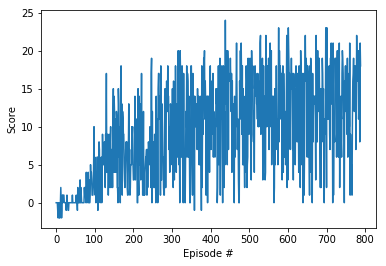

In [45]:
start_time = time.time()
dqn_ber_scores = dqn()
elapsed_time = time.time() - start_time
print('[ info ] Elapsed time --- %s seconds ---' % elapsed_time)

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(dqn_ber_scores)), dqn_ber_scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

## 5.2 Deep Q-Network with Prioritized Experience Replay and QNetwork

In [48]:
agent = Agent(state_size = state_size, action_size = action_size, seed = 0, prioritize = True, ddqn = False, network = QNetwork)
agent

Episode 100	Average Score: 4.46
Episode 200	Average Score: 10.83
Episode 269	Average Score: 13.03
Environment solved in 169 episodes!	Average Score: 13.03
[ info ] Elapsed time --- 893.3060965538025 seconds ---


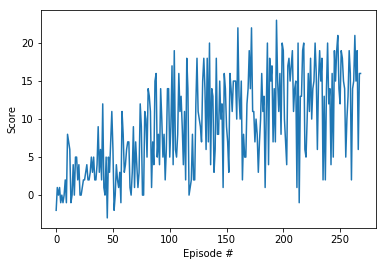

In [49]:
start_time = time.time()
dqn_per_scores = dqn()
elapsed_time = time.time() - start_time
print('[ info ] Elapsed time --- %s seconds ---' % elapsed_time)

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(dqn_per_scores)), dqn_per_scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

## 5.3 Double Deep Q-Network (Double DQN) with Basic Experience Replay and QNetwork

In [53]:
agent = Agent(state_size = state_size, action_size = action_size, seed = 0, prioritize = False, ddqn = True, network = QNetwork)
agent

Episode 100	Average Score: 1.42
Episode 200	Average Score: 3.40
Episode 300	Average Score: 5.84
Episode 400	Average Score: 11.65
Episode 423	Average Score: 13.06
Environment solved in 323 episodes!	Average Score: 13.06
[ info ] Elapsed time --- 424.88810181617737 seconds ---


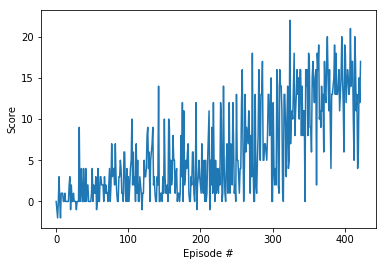

In [51]:
start_time = time.time()
ddqn_ber_scores = dqn()
elapsed_time = time.time() - start_time
print('[ info ] Elapsed time --- %s seconds ---' % elapsed_time)

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(ddqn_ber_scores)), ddqn_ber_scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

## 5.4 Double Deep Q-Network (Double DQN) with Prioritized Experience Replay and QNetwork

In [55]:
agent = Agent(state_size = state_size, action_size = action_size, seed = 0, prioritize = True, ddqn = True, network = QNetwork)
agent

Episode 100	Average Score: 1.60
Episode 200	Average Score: 3.65
Episode 300	Average Score: 8.81
Episode 400	Average Score: 12.84
Episode 406	Average Score: 13.00
Environment solved in 306 episodes!	Average Score: 13.00
[ info ] Elapsed time --- 1369.9635593891144 seconds ---


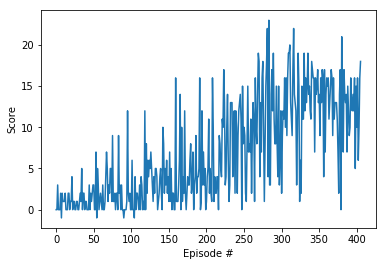

In [56]:
start_time = time.time()
ddqn_per_scores = dqn()
elapsed_time = time.time() - start_time
print('[ info ] Elapsed time --- %s seconds ---' % elapsed_time)

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(ddqn_per_scores)), ddqn_per_scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

## 5.5 Dueling Deep Q-Network with Basic Experience Replay and DNetwork

In [57]:
agent = Agent(state_size = state_size, action_size = action_size, seed = 0, prioritize = False, ddqn = True, network = DNetwork)
agent

Episode 2	Average Score: 14.50
Environment solved in -98 episodes!	Average Score: 14.50
[ info ] Elapsed time --- 2.1516005992889404 seconds ---


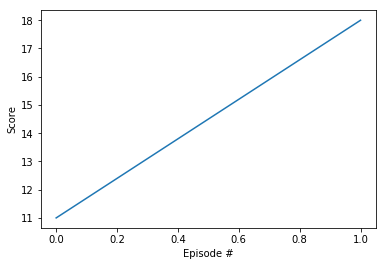

In [59]:
start_time = time.time()
dueling_ddqn_ber_scores = dqn()
elapsed_time = time.time() - start_time
print('[ info ] Elapsed time --- %s seconds ---' % elapsed_time)

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(dueling_ddqn_ber_scores)), dueling_ddqn_ber_scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

## 5.6 Dueling Deep Q-Network with Prioritized Experience Replay and DNetwork

In [60]:
agent = Agent(state_size = state_size, action_size = action_size, seed = 0, prioritize = True, ddqn = True, network = DNetwork)
agent

Episode 100	Average Score: 1.93
Episode 200	Average Score: 6.87
Episode 300	Average Score: 10.39
Episode 400	Average Score: 11.84
Episode 500	Average Score: 12.05
Episode 581	Average Score: 13.02
Environment solved in 481 episodes!	Average Score: 13.02
[ info ] Elapsed time --- 1649.6746618747711 seconds ---


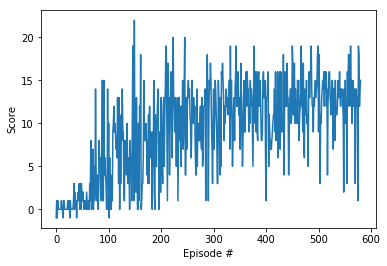

In [61]:
start_time = time.time()
dueling_ddqn_per_scores = dqn()
elapsed_time = time.time() - start_time
print('[ info ] Elapsed time --- %s seconds ---' % elapsed_time)

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(dueling_ddqn_per_scores)), dueling_ddqn_per_scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

When finished, you can close the environment.

In [62]:
env.close()